## Bacterial Colony Growth
[Biomechanical ordering of dense cell populations](https://www.pnas.org/doi/abs/10.1073/pnas.0706805105)

### Imports

In [9]:
# Adding packages
using Pkg
Pkg.add("CellBasedModels")
Pkg.add("CUDA")
Pkg.add("Distributions")
Pkg.add("GLMakie")
Pkg.add("GeometryBasics")

# Enabling packages
using CellBasedModels
using CUDA
using Distributions
using GLMakie
using GeometryBasics
Makie.inline!(true);

   Resolving package versions...
  No Changes to `C:\Users\Marko\.julia\environments\v1.9\Project.toml`
  No Changes to `C:\Users\Marko\.julia\environments\v1.9\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\Marko\.julia\environments\v1.9\Project.toml`
  No Changes to `C:\Users\Marko\.julia\environments\v1.9\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\Marko\.julia\environments\v1.9\Project.toml`
  No Changes to `C:\Users\Marko\.julia\environments\v1.9\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\Marko\.julia\environments\v1.9\Project.toml`
  No Changes to `C:\Users\Marko\.julia\environments\v1.9\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\Marko\.julia\environments\v1.9\Project.toml`
  No Changes to `C:\Users\Marko\.julia\environments\v1.9\Manifest.toml`


### Code

#### Forces Model

In [10]:
rod2D = ABM(2,
    agent = Dict(
            :vx=>Float64,
            :vy=>Float64,
            :theta=>Float64,
            :ω=>Float64,
            :d=>Float64,
            :l=>Float64,
            :m=>Float64,
            :fx=>Float64,
            :fy=>Float64,
            :W=>Float64,
            :pressure=>Float64
        ),    #Local Interaction Parameters

    model = Dict(
            :kn=>Float64,
            :γn=>Float64,
            :γt=>Float64,
            :μcc=>Float64,
            :μcw=>Float64,
            :β=>Float64,
            :βω=>Float64
        ),        #Global parameters

    agentODE = quote

        fx = 0
        fy = 0
        W = 0
        pressure = 0
        @loopOverNeighbors i2 begin

            #Use the model provided in the documentation
            Fijx, Fijy, Wij = CBMModels.rodForces(
                                    x,y,d,l,theta,vx,vy,m,
                                    x[i2],y[i2],d[i2],l[i2],theta[i2],vx[i2],vy[i2],m[i2],
                                    kn,γn,γt,μcc,μcw
                                )

            #Append the interaction forces
            fx += Fijx
            fy += Fijy
            #Append radial forces
            W += Wij
            #Keep track of preassure in the media
            pressure += sqrt(Fijx^2+Fijy^2)
            
        end

        #Equations
        dt(x) =  vx 
        dt(y) =  vy 
        dt(vx) =  -β*vx+fx/m 
        dt(vy) =  -β*vy+fy/m 
        dt(theta) =  ω 
        dt(ω) =  W/(m*(d+l)^2/12+m*d^2)-βω*ω 
        
    end,

    neighborsAlg=CBMNeighbors.CellLinked(cellEdge=4),
    platform=CPU(),
    agentAlg = CBMIntegrators.Heun()
);

In [11]:
function CBMPlots.plotRods2D!(ax, x, y, d, l, angle; kargs...)

    Main.meshscatter!(ax,
                x.+l./2 .*cos.(angle),
                y.+l./2 .*sin.(angle),
                marker=GeometryBasics.Sphere(Point3f0(0,0,0.),Float32(1)),
                markersize=[
                    Point3f0(i/2,i/2,0)
                    for i in d
                ];
                kargs...
            )

    Main.meshscatter!(ax,
                x.-l./2 .*cos.(angle),
                y.-l./2 .*sin.(angle),
                marker=GeometryBasics.Sphere(Point3f0(0,0,0),Float32(1)),
                markersize=[
                    Point3f0(i/2,i/2,0)
                    for i in d
                ];
                kargs...
            )
            
    Main.meshscatter!(ax,
                x,
                y,
                marker=GeometryBasics.Cylinder(Point3f0(-.5,0,0),Point3f0(.5,0,0),Float32(1)),
                markersize=[Point3f0(ll,dd/2,dd/2) for (ll,dd) in zip(l,d)],
                rotations=angle;
                kargs...
            )

    return

end

#### Growth model

In [12]:
rods2dGrowth = ABM(2,
    baseModelInit = [rod2D],

    agent = Dict(
                :lTarget => Float64
            ),

    model = Dict(
                :growth=>Float64,
                :σlTarget=>Float64,
                :lMax=>Float64,
                :α=>Float64
            ),

    agentODE = quote
        dt(l) = growth/(1+α*pressure) #linear growth with growth dependent on the pressure over the cell
    end,

    agentRule = quote #Bound cells
        #Add division
        if l > lTarget
            ww = CBMDistributions.uniform(-.1,.1) #To add some random torque at division time
            #Add a new cell
            @addAgent(
                    x=(l+d)/4*cos(theta)+x,
                    y=(l+d)/4*sin(theta)+y,
                    l=(l-d)/2,
                    ω = ww,
                    lTarget = CBMDistributions.uniform(lMax-σlTarget,lMax+σlTarget) #New target length at which the bactery should divide
                    )
            #Add a second cell
            @addAgent(
                    x=-(l+d)/4*cos(theta)+x,
                    y=-(l+d)/4*sin(theta)+y,
                    l=(l-d)/2,
                    ω = -ww,
                    lTarget = CBMDistributions.uniform(lMax-σlTarget,lMax+σlTarget) #New target length at which the bactery should divide
                    )
            #Remove the old cell
            @removeAgent()
        end
    end,

    neighborsAlg=CBMNeighbors.CellLinked(cellEdge=4),
    platform=CPU(),
    agentAlg=CBMIntegrators.Heun()
);

#### Grow colony from one cell

In [13]:
com = Community(rods2dGrowth,
            N=1,
            dt=0.1,
            simBox = [-100 100;-100 100.],
            );

m = 1/100
g = 1/10000
d = 1
com.kn = 2E6 * (m*g/d)
com.γn = 2.2E2 * sqrt(g/d)
com.γt = 2.2E2 * sqrt(g/d)
com.μcc = 0.1
com.μcw = 0.8
com.β = .8
com.βω = .8
com.growth = 1E-6 * (sqrt(g*d)) *100000
com.lMax = 1.     
com.σlTarget = .2 
com.α = 50

com.m = 1.        
com.d = 1.        
com.l = 2.99      
com.lTarget = 3.  

com.x = 0
com.y = 0
com.theta = 0;

In [14]:
evolve!(com,
        steps=150000,saveEach=1000,
        preallocateAgents=1000,
        saveCurrentState=true,
        progressMessage=(com)->if round(Int,com.t/com.dt)%10000 == 0; println("Step: ",round(Int,com.t/com.dt), " N: ", com.N); end)

Step: 10000 N: 4
Step: 20000 N: 9
Step: 30000 N: 17
Step: 40000 N: 32
Step: 50000 N: 66
Step: 60000 N: 128
Step: 70000 N: 227
Step: 80000 N: 368
Step: 90000 N: 585
Step: 100000 N: 885
Step: 110000 N: 1000
Step: 120000 N: 1000
Step: 130000 N: 1000
Step: 140000 N: 1000
Step: 150000 N: 1000


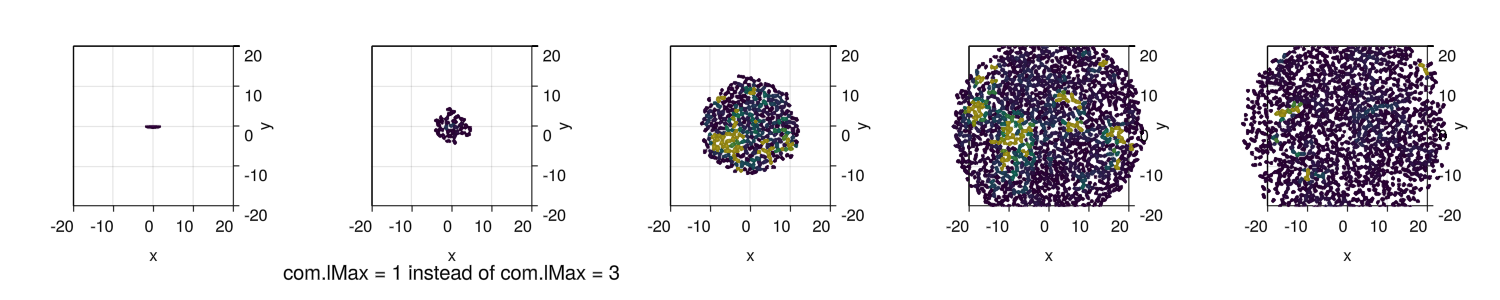

In [15]:
fig = Figure(resolution=(1500,300))

for (i,j) in enumerate([1:round(Int,length(com)/4):length(com);length(com)])
    ax = Axis3(fig[1,i],
                azimuth=3*π/2,
                elevation=π/2,
                zlabelvisible=false,
                zticklabelsvisible=false,
                zgridvisible=false,
                zspinesvisible=false
            )

    CBMPlots.plotRods2D!(ax,com[j][:x],com[j][:y],com[j][:d],com[j][:l],com[j][:theta],
            color=com[j][:pressure], colorrange=(0,0.05))
    xlims!(-20,20)
    ylims!(-20,20)
end

Label(fig[2, 1:3], "com.lMax = 1 instead of com.lMax = 3", fontsize = 20, halign = :center)
display(fig)
save("D:/JuliaProjects/CellBasedModelsF1/results/testing/bacterial_colony_growth_growth_testing_16.png", fig)